In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn import metrics

import time
import pickle 

import pandas as pd

## Calculate the final score

## Evaluation Metric:

Our goal to to reduce unintented bias as much as possible so we will use a special matric. 

we are refering the following information from <a href="https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation" target="_blank"><b>here</b></a>.

We will use metric that combines several submetrics to balance overall performance with various aspects of unintended bias.


<ol>
<li><b>Overall AUC</b><br>
   This is the ROC-AUC for the full evaluation set.</li><br><br>

<li><b>Bias AUCs</b><br>
   Here we calculate the ROC-AUC on three specific subsets of the test set for each identity, each capturing a different      aspect of unintended bias.<br><br>

<ol type="a"><li><b>Subgroup AUC:</b><br> 
       Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.</li><br>
<li><b>BPSN (Background Positive, Subgroup Negative) AUC:</b><br> 
       Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.</li><br>

<li><b>BNSP (Background Negative, Subgroup Positive) AUC:</b><br>
       Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.</li>
</li><br><br>

In [2]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


## Generalized Mean of Bias AUCs

To combine the per-identity Bias AUCs into one overall measure, we calculate their generalized mean as defined below:

$$M_p(m_s) = \left(\frac{1}{N} \sum_{s=1}^{N} m_s^p\right)^\frac{1}{p}$$


where: 

$$  M_p = the \ pth\ power\ mean\ function$$
$$m_s = the\ bias\ metric\ m \ calulated \ for \ subgroup$$
$$N = number \ of \ identity \ subgroups$$

## Final Metric

$$score = w_0 AUC_{overall} + \sum_{a=1}^{A} w_a M_p(m_{s,a})$$

where:

$$A = number \ of \ submetrics \ (3)$$

$$m_{s,a} = bias \ metric \ for \ identity \ subgroup \ s \ using \ submetric \ a$$

$$w_a = a \ weighting \ for \ the \ relative \ importance \ of \ each \ submetric; \ all \ four \ w \ values \ set \ to \ 0.25$$

In [3]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
#get_final_metric(bias_metrics_df, calculate_overall_auc(X_test_TFIDF, MODEL_NAME))

## 2. Data Pre-processing and vectorizing:

In [4]:
train_embd = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', sep=',', quotechar='"')

In [5]:
##REF:https://www.kaggle.com/christofhenkel/how-to-preprocessing-for-glove-part1-eda

import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [6]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

In [7]:

GLOVE_EMBEDDING_PATH="../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl"
tic = time.time()
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_PATH)
print(f'loaded {len(glove_embeddings)} word vectors in {time.time()-tic}s')

loaded 2196008 word vectors in 10.154787540435791s


In [8]:
import gc
del train_embd
del glove_embeddings
gc.collect()

20

# Importing the preprocessed data

In [17]:
train_embd = pd.read_csv('../input/jigshwpreprocesseddata/train_embd.csv', sep=',', quotechar='"')

In [18]:
train_embd.shape

(1804874, 46)

# Deep Learning Models

In [19]:
from sklearn import model_selection
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence



import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Input,\
 Embedding,BatchNormalization,Bidirectional,GlobalMaxPool1D,concatenate

from tensorflow.keras.models import model_from_json  

In [20]:
train_embd['comment_text'] = train_embd['comment_text'].astype(str) 

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

TOXICITY_COLUMN = 'target' 

# Converting taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train_embd = convert_dataframe_to_bool(train_embd)

# Spliting Data in Train and Test

In [21]:
num_classes=2

train_df, test_df = model_selection.train_test_split(train_embd, test_size=0.2)
train_df, validate_df = model_selection.train_test_split(train_embd, test_size=0.1)
# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(train_df['target'], num_classes)
y_test= tf.keras.utils.to_categorical(test_df['target'], num_classes)
y_validate = tf.keras.utils.to_categorical(validate_df['target'], num_classes)

print('%d train comments, %d validate comments %d test comments' % (len(train_df), len(validate_df),len(test_df)))

1624386 train comments, 180488 validate comments 360975 test comments


In [22]:
import gc

#delete when no longer needed
del train_embd
#collect residual garbage
gc.collect()

100

## Create a text tokenizer

In [24]:



MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

X_train = pad_text(train_df[TEXT_COLUMN], tokenizer)
X_test = pad_text(test_df[TEXT_COLUMN], tokenizer)
X_validate = pad_text(validate_df[TEXT_COLUMN], tokenizer)

In [25]:
#delete when no longer needed
del train_df
#del test_df
del validate_df
#collect residual garbage
gc.collect()

20

In [26]:
EMBEDDINGS_DIMENSION = 300
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

n unknown words (glove):  200094


In [27]:
glove_matrix.shape

(352864, 300)

In [28]:


import pickle

# saving
with open('tokenizer_2_layer_CNN.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle)

# loading
#with open('tokenizer.pickle', 'rb') as handle:
#    tokenizer = pickle.load(handle)



## 2 Layer LSTM Model 2

In [29]:
def CNN_Model_get():
        """Returns (input_layer, output_layer)"""
        input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[glove_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        #x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs=input,outputs=output)
        return model

In [30]:
np.random.seed(7)
CNN_Model = CNN_Model_get()
CNN_Model.summary()
CNN_Model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 300)          105859200 
_________________________________________________________________
conv1d (Conv1D)              (None, 250, 128)          76928     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 128)          49280     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 128)           65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0     

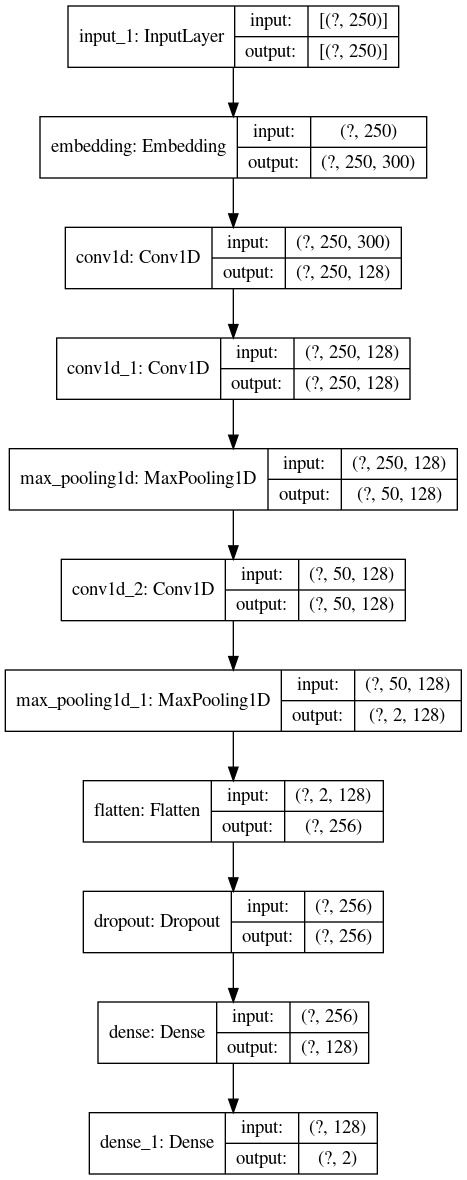

In [31]:
from tensorflow.keras.utils import plot_model

plot_model(CNN_Model, 'CNN_1.png', show_shapes=True)

In [32]:
#https://www.kaggle.com/yuliagm/how-to-work-with-big-datasets-on-16g-ram-dask
# checkpoint
# Configure the TensorBoard callback and fit your model

#tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")

filepath="weights_2_layer_cnn.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]    

history=CNN_Model.fit(X_train, y_train, verbose=1,epochs=40,validation_data=(X_validate, y_validate) ,batch_size=512,callbacks=callbacks_list)

Epoch 1/40
3173/3173 [==============================] - ETA: 0s - loss: 0.1518 - accuracy: 0.9448
Epoch 00001: val_loss improved from inf to 0.14177, saving model to weights_2_layer_cnn.best.hdf5
3173/3173 [==============================] - 205s 64ms/step - loss: 0.1518 - accuracy: 0.9448 - val_loss: 0.1418 - val_accuracy: 0.9455
Epoch 2/40
3172/3173 [============================>.] - ETA: 0s - loss: 0.1375 - accuracy: 0.9488
Epoch 00002: val_loss improved from 0.14177 to 0.13617, saving model to weights_2_layer_cnn.best.hdf5
3173/3173 [==============================] - 203s 64ms/step - loss: 0.1375 - accuracy: 0.9488 - val_loss: 0.1362 - val_accuracy: 0.9489
Epoch 3/40
3172/3173 [============================>.] - ETA: 0s - loss: 0.1337 - accuracy: 0.9499
Epoch 00003: val_loss improved from 0.13617 to 0.13573, saving model to weights_2_layer_cnn.best.hdf5
3173/3173 [==============================] - 203s 64ms/step - loss: 0.1337 - accuracy: 0.9499 - val_loss: 0.1357 - val_accuracy: 0.9

In [33]:
history.history

{'loss': [0.15182581543922424,
  0.13748373091220856,
  0.13368795812129974,
  0.1306769847869873,
  0.1280343234539032,
  0.12533801794052124,
  0.12287233769893646,
  0.12040245532989502,
  0.11789199709892273,
  0.1155644953250885,
  0.11331085115671158,
  0.11102348566055298,
  0.10879358649253845,
  0.10675350576639175,
  0.10463821142911911,
  0.1027940884232521,
  0.10101158171892166,
  0.0992208942770958,
  0.09751275181770325,
  0.0959380567073822,
  0.09427259862422943,
  0.0931740552186966,
  0.09142904728651047,
  0.0903456062078476,
  0.0891958549618721,
  0.08772309124469757,
  0.08666502684354782,
  0.08539296686649323,
  0.0844949334859848,
  0.08340580016374588,
  0.08198095858097076,
  0.08127135038375854,
  0.08034386485815048,
  0.07949107140302658,
  0.0786871463060379,
  0.07758113741874695,
  0.0765882059931755,
  0.07604076713323593,
  0.075433149933815,
  0.07458730787038803],
 'accuracy': [0.9447926878929138,
  0.9487873911857605,
  0.9498770833015442,
  0.950

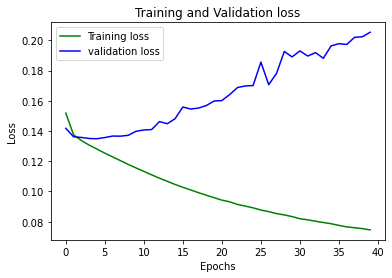

In [34]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = np.range(1,1)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

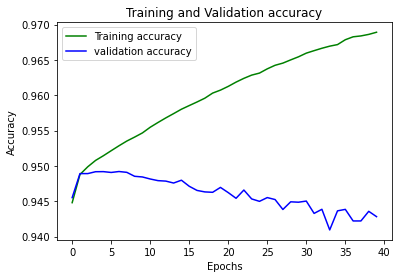

In [35]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,41)
plt.plot(loss_train, 'g', label='Training accuracy')
plt.plot(loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
#new_model2 = tf.keras.models.load_model('/content/gdrive/My Drive/Checkpoints/Self Case Study 1/CNN LSTM Model 1/saved_model2')
from sklearn.metrics import roc_auc_score
predict_y = CNN_Model.predict(X_test)
print(roc_auc_score(test_df['target'].values, predict_y[:,1]))

0.9848995302217435


In [37]:
predict_y = CNN_Model.predict(X_test)
MODEL_NAME = 'CNN_Model'
test_df[MODEL_NAME] = list(predict_y[:,1])
bias_metrics_df = compute_bias_metrics_for_model(test_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
2,homosexual_gay_or_lesbian,2204,0.938054,0.943891,0.984833
6,black,3014,0.947119,0.941781,0.987152
7,white,4910,0.947451,0.941858,0.988140
5,muslim,4298,0.957887,0.960345,0.984809
4,jewish,1553,0.964186,0.969199,0.984431
0,male,8935,0.968409,0.971104,0.983712
1,female,10769,0.969702,0.972226,0.984241
8,psychiatric_or_mental_illness,980,0.978058,0.975454,0.984970
3,christian,8206,0.980482,0.982122,0.983889


In [38]:
CNN_model_Model_1=get_final_metric(bias_metrics_df, calculate_overall_auc(test_df, MODEL_NAME))
CNN_model_Model_1

0.9729976527246499

# Submit

In [39]:
test_embd = pd.read_csv('../input/jigshwpreprocesseddata/test_sub.csv', sep=',', quotechar='"')
test_embd['comment_text'] = test_embd['comment_text'].astype(str)
X_test_sub = pad_text(test_embd['comment_text'], tokenizer)
predict_y = CNN_Model.predict(X_test_sub)
test_embd['prediction'] = list(predict_y[:,1])

In [40]:
submission = pd.DataFrame.from_dict({
    'id': test_embd['id'],
    'prediction': list(predict_y[:,1])
})

In [41]:
submission.head()

,id,prediction
0,7097320,4.749170e-07
1,7097321,1.103860e-02
2,7097322,3.048548e-05
3,7097323,3.097666e-09
4,7097324,1.333274e-08


In [42]:
submission.to_csv('submission.csv', index=False)

## **AUC Score on Test Data is 0.9823**
## **Evaluation Metric Score on Test Data is 0.9715**
## **Kaggle Score for submission test file on Private leaderboard: 0.86595**<br>
<img src="https://i.ibb.co/XYVgrmW/cnn-2-layer.png" alt="cnn-2-layer" border="0">